Initial idea is to verify that press releases affect the stock price. 

1. Test that press releases affect the price
2. Get the press release of that stock for that day
    a. Do a sentiment analysis on the title
    b. Check if + sentiment sent the stock up or vice versa


Data gotten here: https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar

In [37]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests

load_dotenv()
plt.style.use("dark_background")


pd.set_option("display.max_columns", None)

In [40]:
def query_ollama_llama(
    prompt,
    model="llama3.2",
    api_url="http://localhost:11434/api/generate",
    stream=False,
    max_tokens=512,
    temperature=0.7,
):
    """
    Send a request to Llama 3.2 running through Ollama.

    Args:
        prompt (str): The input prompt for the model
        model (str): The model name in Ollama (e.g., "llama3.2")
        api_url (str): The URL endpoint of your Ollama API
        stream (bool): Whether to stream the response
        max_tokens (int): Maximum number of tokens to generate
        temperature (float): Controls randomness in generation (0.0-1.0)

    Returns:
        dict: The response from the model
    """
    headers = {"Content-Type": "application/json"}

    payload = {
        "model": model,
        "prompt": prompt,
        "stream": stream,
        "options": {"num_predict": max_tokens, "temperature": temperature},
    }

    try:
        response = requests.post(api_url, headers=headers, data=json.dumps(payload))

        if response.status_code == 200:
            return response.json()
        else:
            return {
                "error": f"Request failed with status code {response.status_code}",
                "details": response.text,
            }

    except requests.exceptions.RequestException as e:
        return {"error": f"Request exception: {str(e)}"}

# Get the Catalyst events

In [3]:
# Load JSON from a file
with open("historical-catalyst-calendar.json", "r") as file:
    data = json.load(file)

data = data["data"]["data"]

In [4]:
clean_data = []

bad_keys = ["price_change_sparkline", "statuses"]

for item in data:
    for key in bad_keys:
        if key in item:
            del item[key]
    clean_data.append(item)

In [5]:
df = pd.DataFrame(clean_data)
good_cols = ["date", "note", "company_ticker"]
dfc = df[good_cols]

In [ ]:
# df.to_csv("historical-catalyst-calendar.csv", index=False)

In [7]:
dfc.sort_values(by="company_ticker", inplace=True)

/var/folders/y6/38m_mn3x0hd4sx1rhttwsz540000gn/T/ipykernel_63927/3210654591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc.sort_values(by="company_ticker", inplace=True)


In [8]:
# quick stats on the data
print("Sample length: ", len(dfc))

tickers = dfc["company_ticker"].unique()
print("Unique tickers ", len(dfc["company_ticker"].unique()))

Sample length:  24
Unique tickers  21


# Get the stock price

In [9]:
from polygon import RESTClient

polygon_api = os.getenv("PLOYGON_API")

In [10]:
client = RESTClient(api_key=polygon_api)

In [ ]:
stock_data = []
counter = 0

for index, row in dfc.iterrows():

    ticker = row["company_ticker"]  # The specific ticker you're interested in
    start_time = (pd.to_datetime(row["date"]) - pd.Timedelta(1)).strftime("%Y-%m-%d")
    end_time = (pd.to_datetime(row["date"]) + pd.Timedelta(1)).strftime("%Y-%m-%d")

    # List Aggregates (Bars)
    aggs = []
    for a in client.list_aggs(
        ticker=ticker,
        multiplier=60,
        timespan="minute",
        from_=start_time,
        to=end_time,
    ):
        aggs.append(a)
    stock_data.append({"ticker": ticker, "date": start_time, "data": aggs})
    counter += 1

Phase 2 interim data from MDS reported that at 6 months all participants exhibited brain volume declines consistent with MSA progression; however, the clinical responders maintained stable brain volumes at 12 months, noted October 2, 2024.


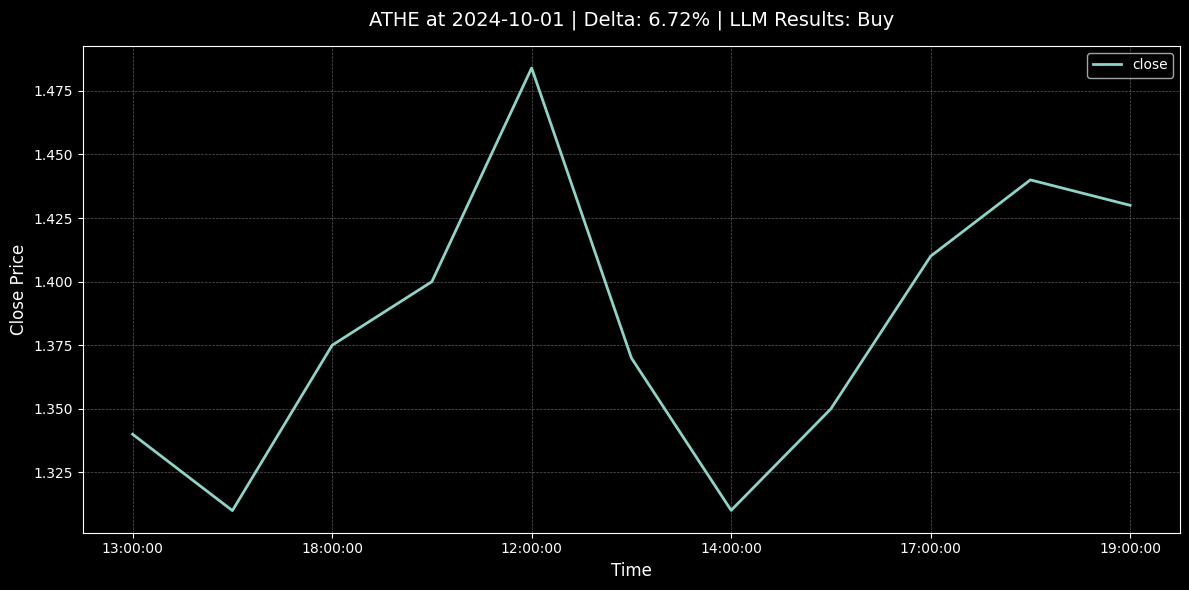

Phase 1 deprioritized, looking for a partnership to continue program, noted October 7, 2024.


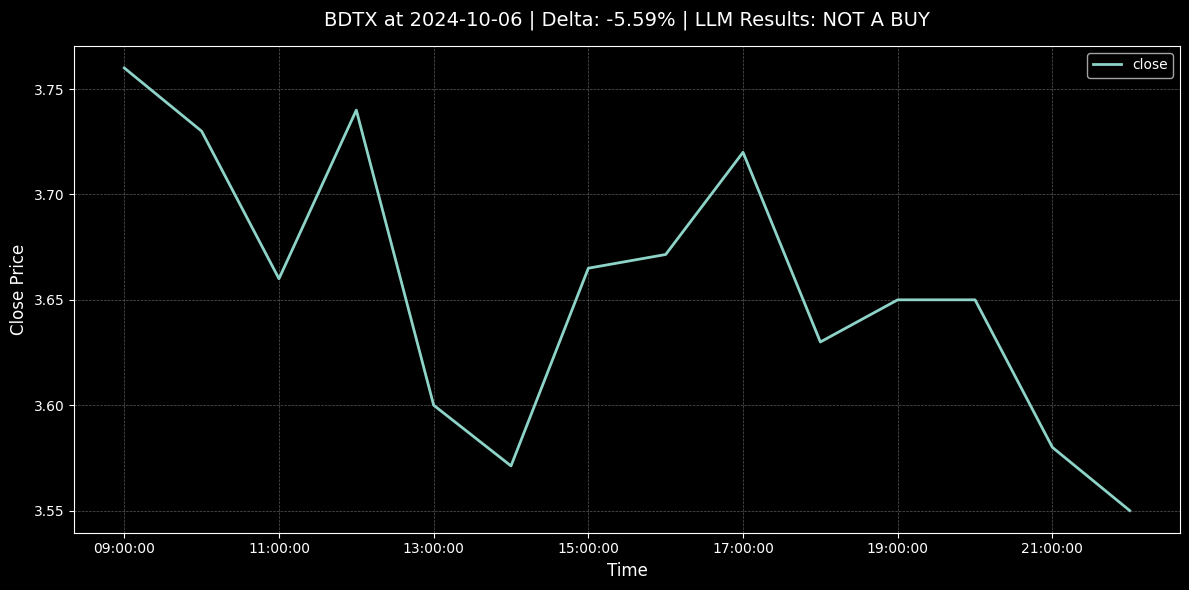

Approved October 7, 2024.


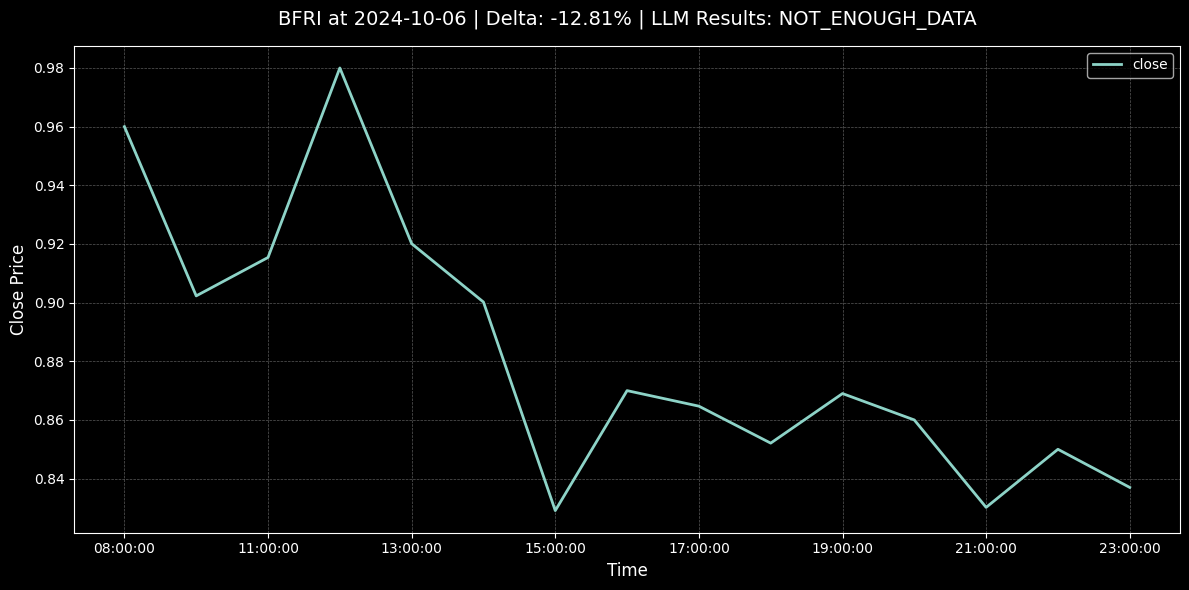

Preclinical data demonstrated improvements in motor and cognitive function, which persisted even after the treatment was discontinued, suggesting a lasting neuroprotective effect, noted October 7, 2024.


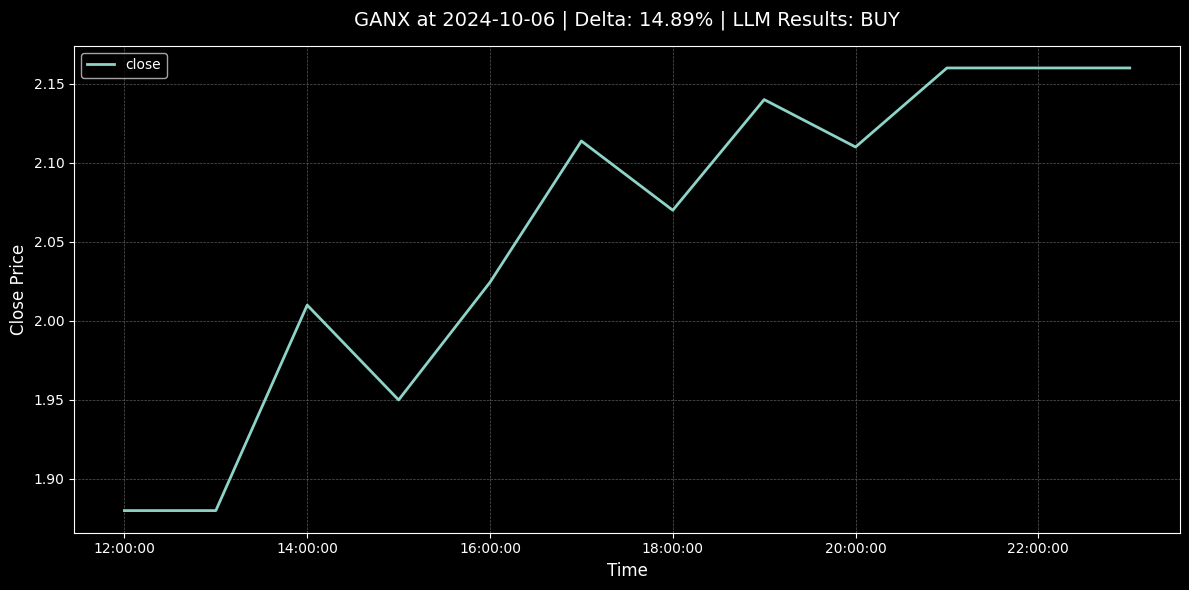

Phase 2 data reported a 10.4% protective efficacy against moderate to severe campylobacteriosis following challenge with Campylobacter compared to the placebo group, noted October 4, 2024.


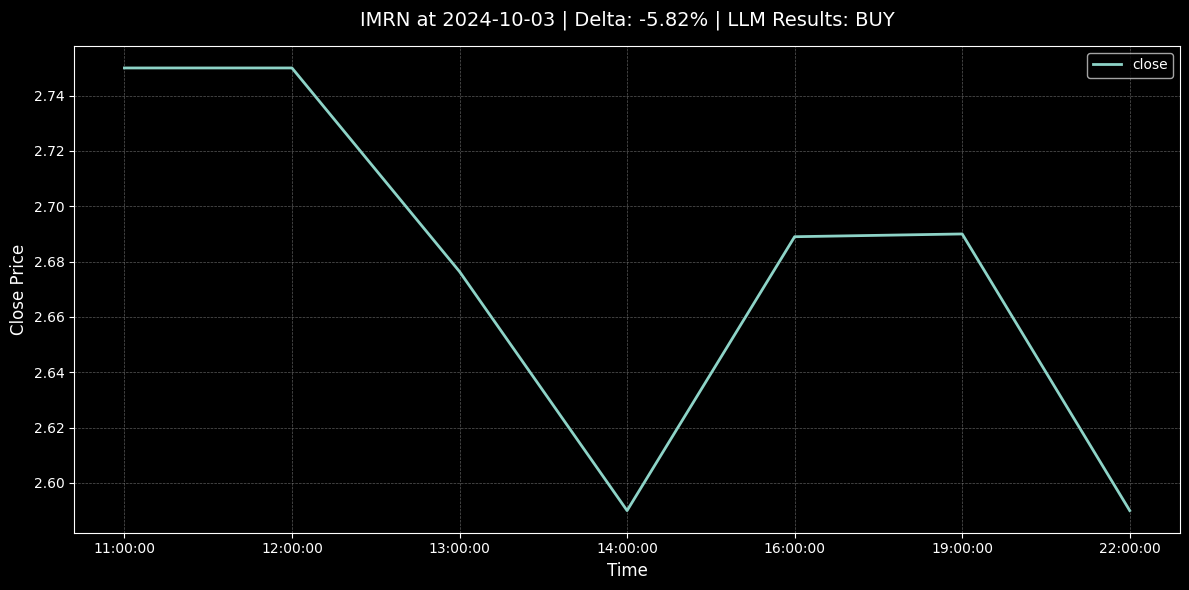

Preclinical data from the Oligonucleotide Therapeutics Society reported that treatment achieved AAT levels between MM and MZ in rodents as early as Week 1,  noted October 7, 2024.


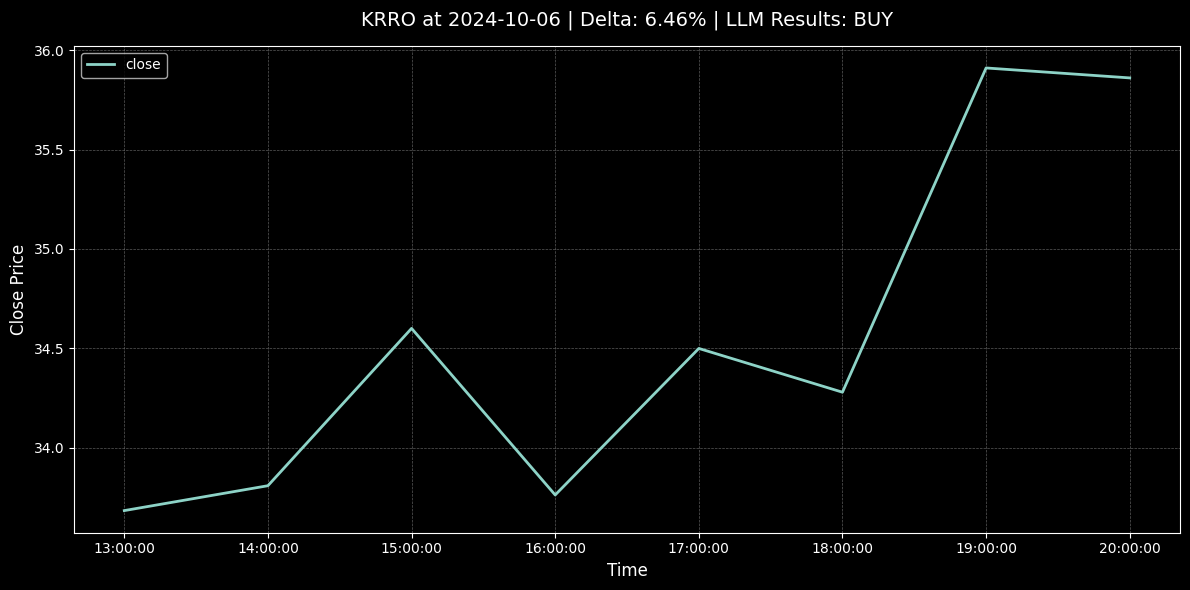

Phase 2 data presented at ASTRO showed 100% 36-month overall survival (OS) and progression-free survival (PFS) rates in fully treated patients. Notably, 88% of patients achieved a complete metabolic response, with the treatment demonstrating a solid safety profile and minimal toxicity, noted October 2, 2024.


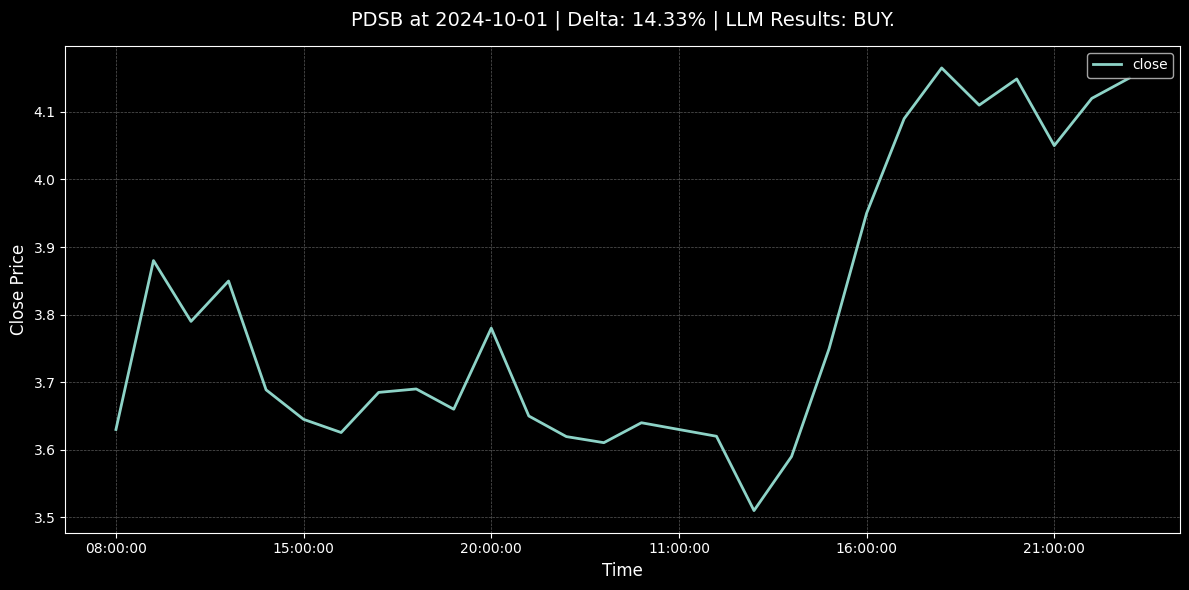

Phase 2b data from CNS reported a statistically significant reduction in tumor volume rate change was seen in tumors receiving > 100 Gy absorbed dose, noted October 1, 2024.


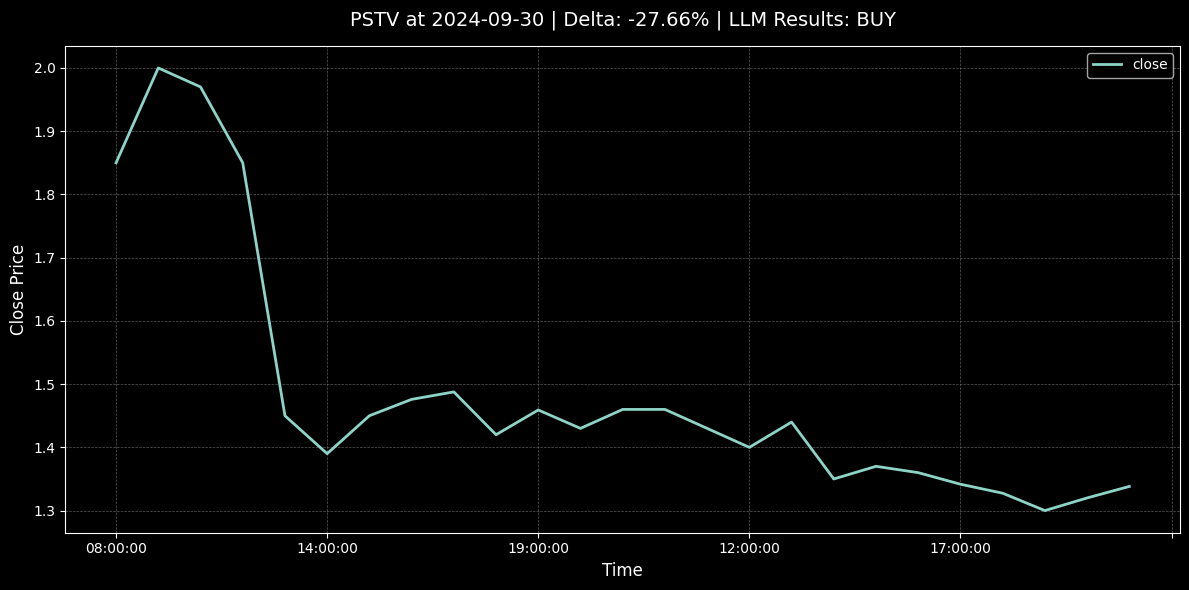

Phase 3 study met its primary endpoint, demonstrating a statistically significant and clinically meaningful improvement in motor function, as measured by the Hammersmith Functional Motor Scale Expanded (HFMSE), compared to placebo, noted October 7, 2024.


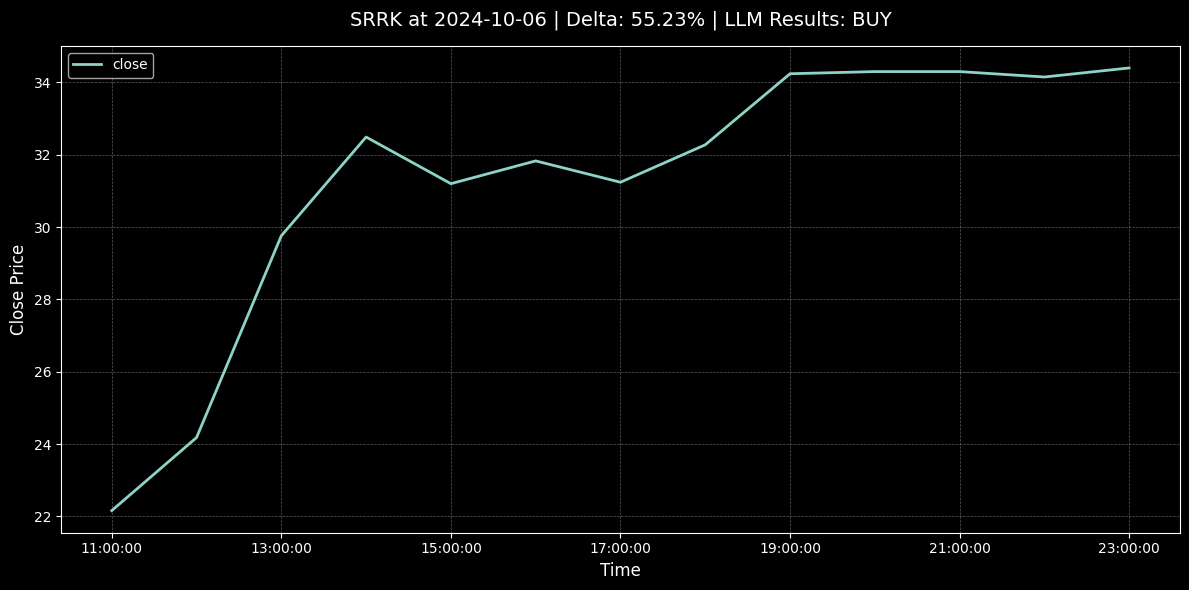

Phase 1b/2 DSMC positive review with 15 SAEs were reported among 10 patients, with the most common SAE being infections and infestations, including sepsis, noted October 3, 2024.


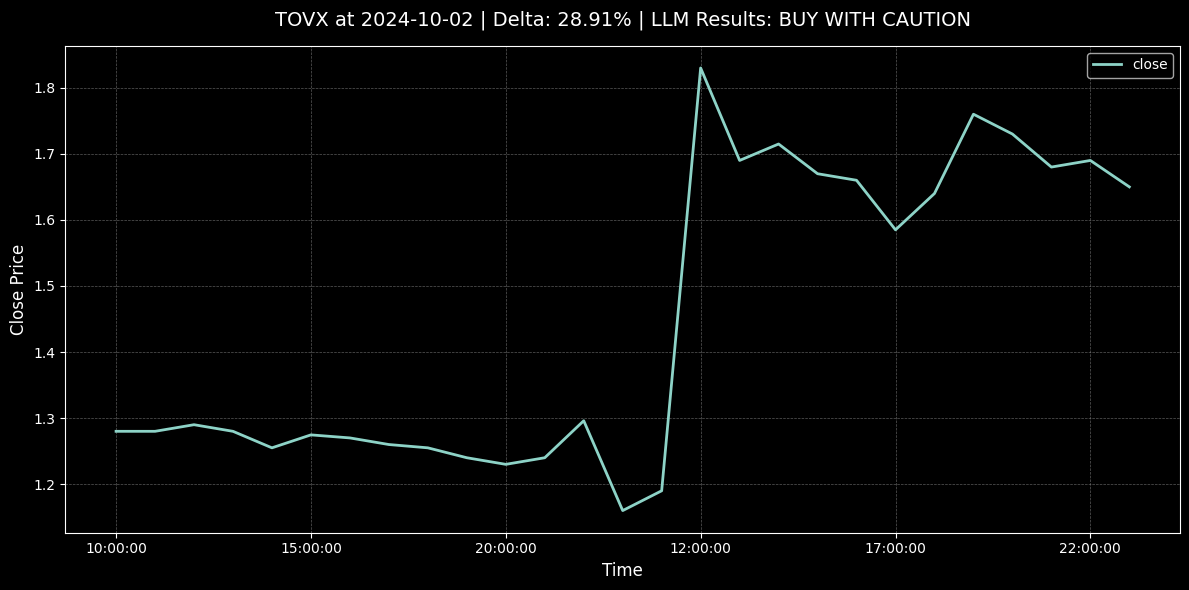

In [54]:
for data in stock_data:

    df1 = pd.DataFrame(data["data"])

    if df1.empty:
        print("ERROR: No data for ", data["ticker"], data["date"])
        continue
    df1["timestamp"] = pd.to_datetime(df1["timestamp"], unit="ms")
    df1["timestamp"] = df1["timestamp"].dt.strftime("%H:%M:%S")
    diff = ((df1["close"].iloc[-1] - df1["close"].iloc[0]) / df1["close"].iloc[0]) * 100

    # Filter the low delta, meaning the stock didn't move much
    # TODO: Compare the news of the stocks with low Delta vs news of high delta stocks
    if diff < 5 and not diff < -5:
        continue
    ticker = data["ticker"]
    note = dfc[(dfc["company_ticker"] == ticker)]["note"].values[0]
    print(note)
    main_prompt = f"Youre a biotech investor. Given the following note/press release, make a decision on the stock if i should buy or no. Return at max a 3 word response. If the press release is not enough to make a judgement return NOT_ENOUGH_DATA \n\n {note}"

    llm_result = query_ollama_llama(main_prompt)["response"]
    # Plot the data
    ax = df1.plot(
        x="timestamp",
        y="close",
        figsize=(12, 6),
        linewidth=2,
    )
    ax.set_title(
        f"{ticker} at {data['date']} | Delta: {diff:.2f}% | LLM Results: {llm_result}",
        fontsize=14,
        pad=15,
    )
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Close Price", fontsize=12)

    # Customize appearance
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

## NEXT: Verify the time of the press release with respect to the stock jump

Currently the above charts show the delta but the timestamp looks fucked. <br>
Why dont all the stocks start at 9? Why some of them start 13:25? <br> Is there a issue with the data provider? 


## Next: Find the ones with the highest intraday delta and check the release that triggered it 

1. Try to do basic NLP sentiment analysis